<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 3. Обучение с учителем. Методы классификации
## <center>Часть 3. Соревнование Kaggle Inclass по автострахованию

[Соревнование](https://inclass.kaggle.com/c/hse-addprofeduc-2-ml-contest), исходное <a href="http://microsoftbi.ru/2015/06/06/hackathon2015ml/">описание</a> задачи. 

Задача бинарной классификации. Имеются автомобили, для которых указан регистрационный номер и марка, и выплаты страховой компании по инцидентам с участием данного автомобиля. Страховая компания для себя решает, много она заплатила или мало. 

Объекты - автомобили.

Признаки:

- ID записи
- Регистрационный номер автомобиля (auto_number, строка)
- Марка автомобиля (auto_brand, строка)
- Сумма выплаты при попадании водителя в аварию (compensated, целое положительное число)
- Тип выплаты (too_much) (много/мало, 1 или 0)

### Загрузка и первичный анализ данных

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%pylab inline
import seaborn as sns
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


**Считаем обучающую и тестовую выборку, создав объекты Pandas DataFrame.**

In [4]:
train_df = pd.read_csv("../../data/car_insurance_train.csv",
                      index_col=0)
test_df = pd.read_csv("../../data/car_insurance_test.csv",
                        index_col=0)

In [5]:
train_df.describe(include='all')

,auto_number,auto_brand,compensated,too_much
count,817,817,817.000000,817.000000
unique,497,13,NaN,NaN
top,M0299X197RUS,Ford Focus,NaN,NaN
freq,5,658,NaN,NaN
mean,NaN,NaN,7939.779682,0.516524
std,NaN,NaN,15688.445587,0.500033
min,NaN,NaN,100.000000,0.000000
25%,NaN,NaN,1000.000000,0.000000
50%,NaN,NaN,3000.000000,1.000000
75%,NaN,NaN,8000.000000,1.000000


In [6]:
train_df.head(10)

,auto_number,auto_brand,compensated,too_much
id,,,,
1,Y163O8161RUS,Ford Focus,3200,1
2,E432XX77RUS,Toyota Camry,6500,0
3,7184TT36RUS,Ford Focus,2100,0
4,X582HE161RUS,Ford Focus,2000,1
5,E34877152RUS,Ford Focus,6100,1
6,92918M178RUS,Ford Focus,5700,0
7,E53488152RUS,Ford Focus,1800,1
8,X4128H125RUS,Ford Focus,500,0
9,C593EY154RUS,Ford Focus,1000,0


In [7]:
test_df.describe(include='all')

,auto_number,auto_brand,compensated
count,100,100,100.00000
unique,95,9,NaN
top,O718MM163RUS,Ford Focus,NaN
freq,3,81,NaN
mean,NaN,NaN,6712.00000
std,NaN,NaN,11093.92663
min,NaN,NaN,100.00000
25%,NaN,NaN,1000.00000
50%,NaN,NaN,3000.00000
75%,NaN,NaN,7050.00000


In [8]:
test_df.head()

,auto_number,auto_brand,compensated
id,,,
1,E29677161RUS,Ford Focus,6000
2,T020MM116RUS,Skoda Octavia,3000
3,C798ET50RUS,Ford Focus,5000
4,Y7719C197RUS,Ford Focus,4600
5,9502XX38RUS,Skoda Octavia,3000


**Распределение признака "марка авто".**

In [9]:
train_df['auto_brand'].value_counts()

Ford Focus            658
Skoda Octavia          51
Volkswagen Golf        24
Volkswagen Passat      21
Toyota Corolla         18
Toyota Camry           17
Ford Mondeo             8
Volkswagen Jetta        7
Volkswagen Touareg      4
Volkswagen              3
BMW                     3
Volvo                   2
Audi                    1
Name: auto_brand, dtype: int64

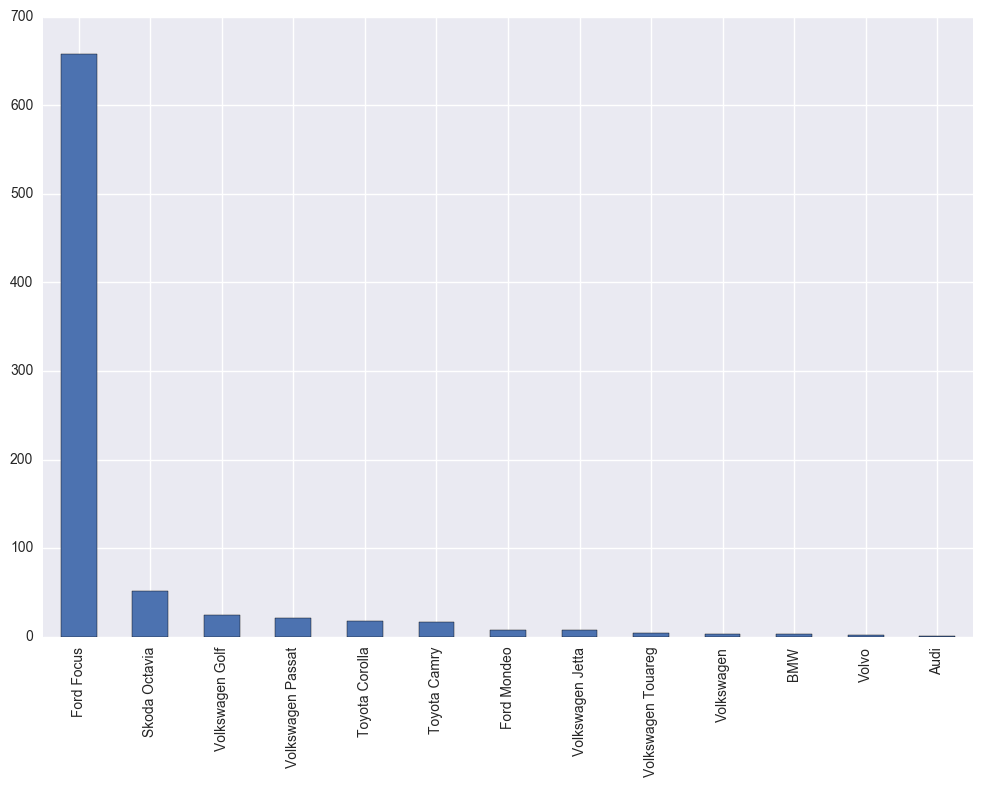

In [10]:
train_df['auto_brand'].value_counts().plot(kind='bar')

In [11]:
test_df['auto_brand'].value_counts()

Ford Focus           81
Skoda Octavia         8
Volkswagen Passat     3
Toyota Corolla        2
Ford Mondeo           2
BMW                   1
Volkswagen Jetta      1
Toyota Camry          1
Volkswagen Golf       1
Name: auto_brand, dtype: int64

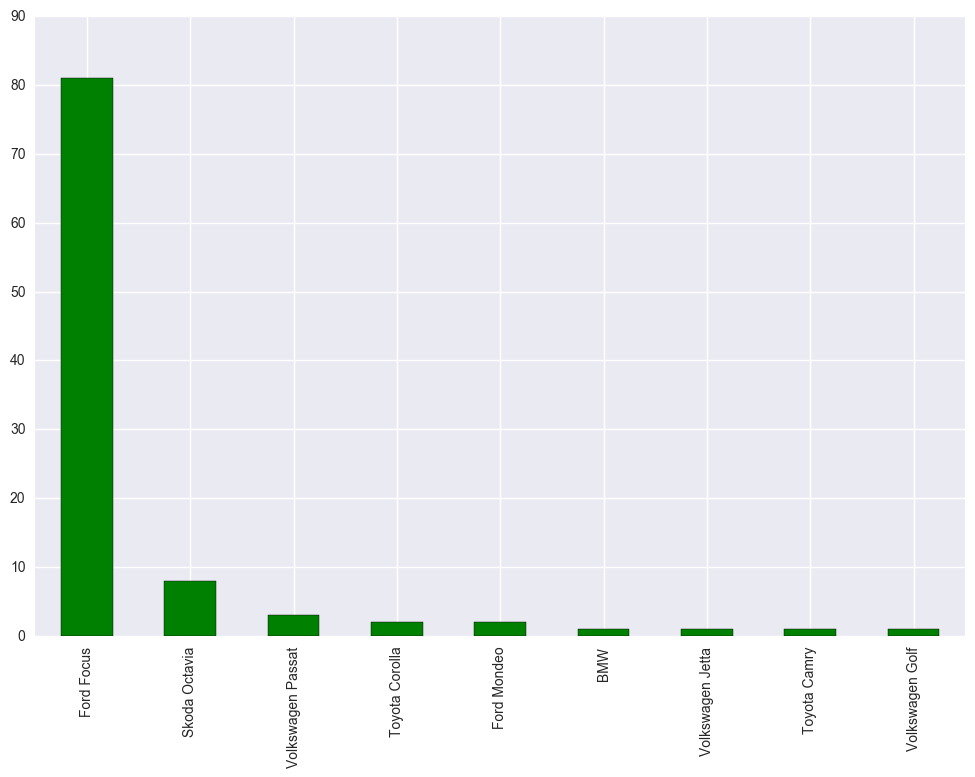

In [12]:
test_df['auto_brand'].value_counts().plot(kind='bar', color='green')

**Распределение признака "сумма выплат".**

In [13]:
train_compensated = train_df['compensated'].value_counts()
train_compensated.head()

500     73
1000    46
2000    37
1500    27
1600    22
Name: compensated, dtype: int64

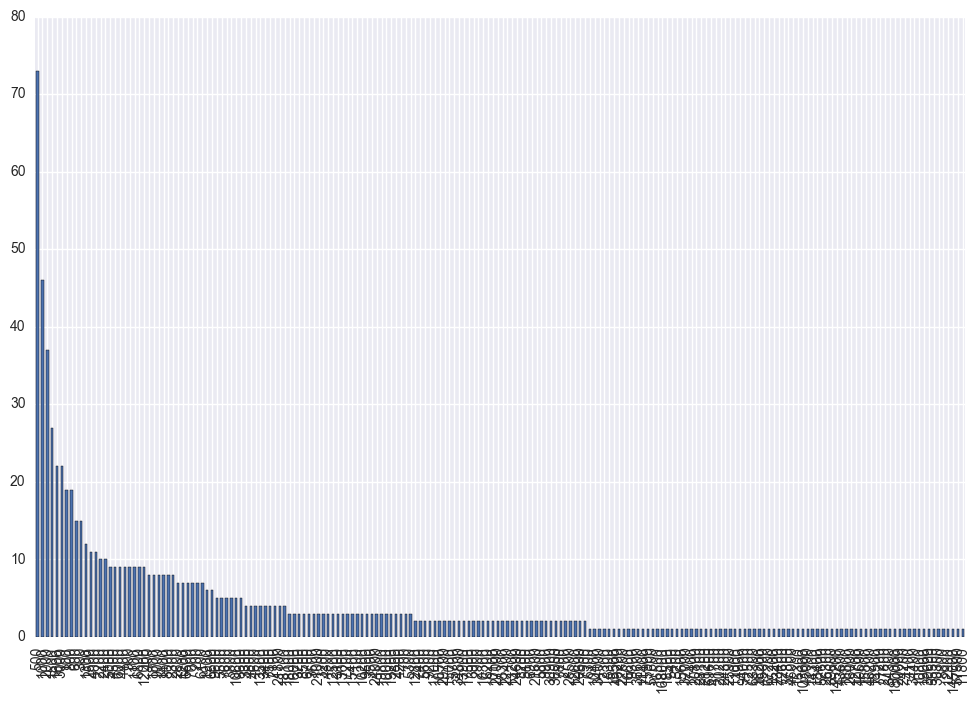

In [14]:
train_compensated.plot(kind='bar')

**Распределение степенное. Отсортируем по выплатам.**

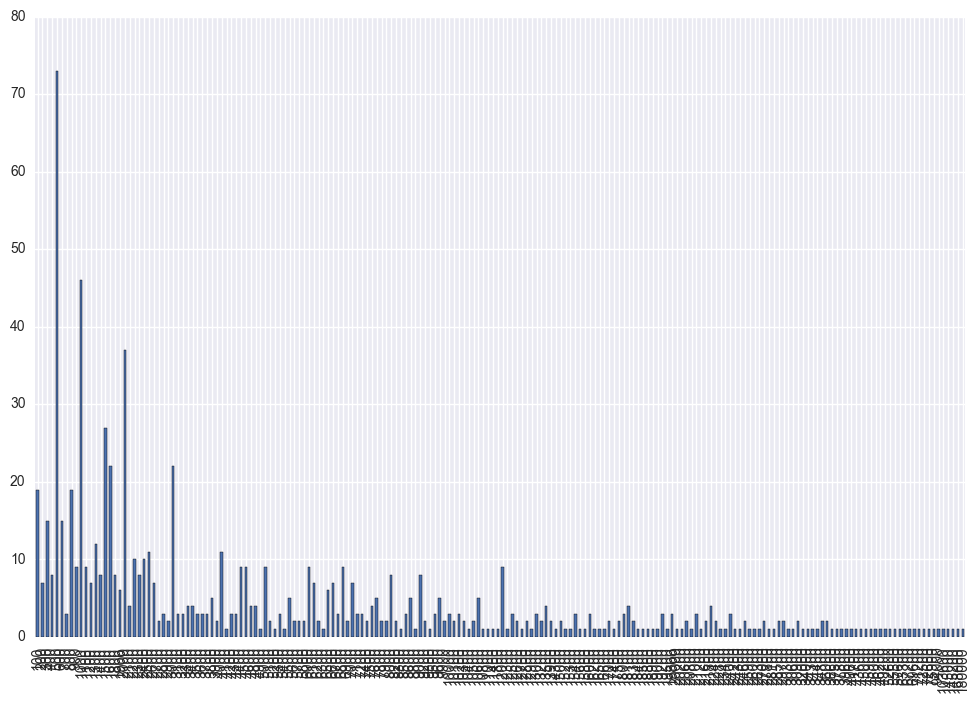

In [15]:
train_df.sort_index(by='compensated')['compensated'].value_counts().sort_index().plot(kind="bar")

**То же самое, только для выплат < 2000.**

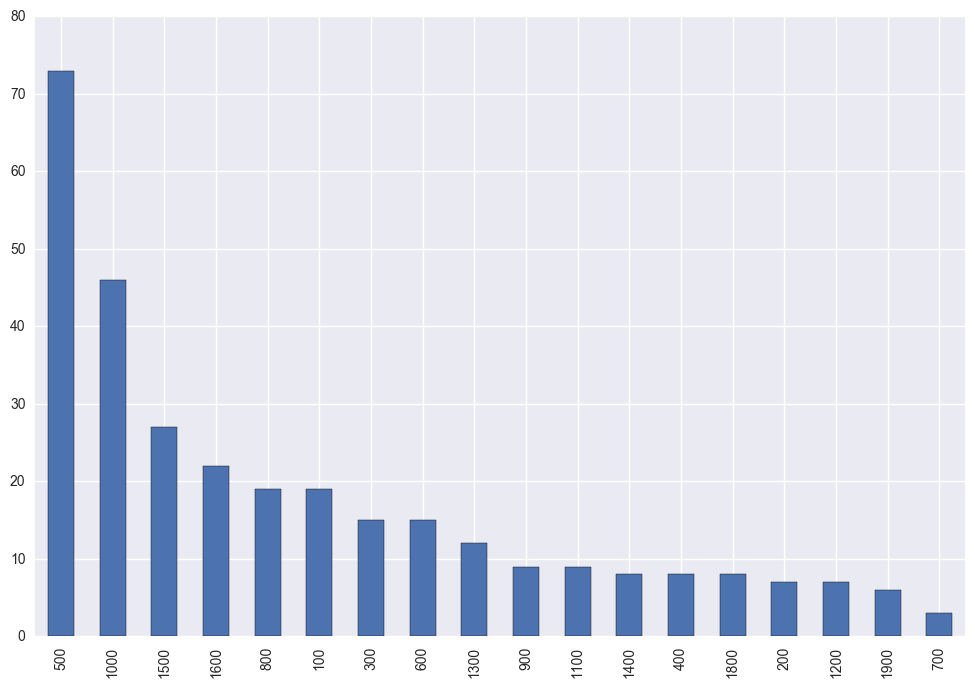

In [16]:
train_df[train_df['compensated'] < 2000]['compensated'].value_counts().plot(kind='bar', by='compensated')

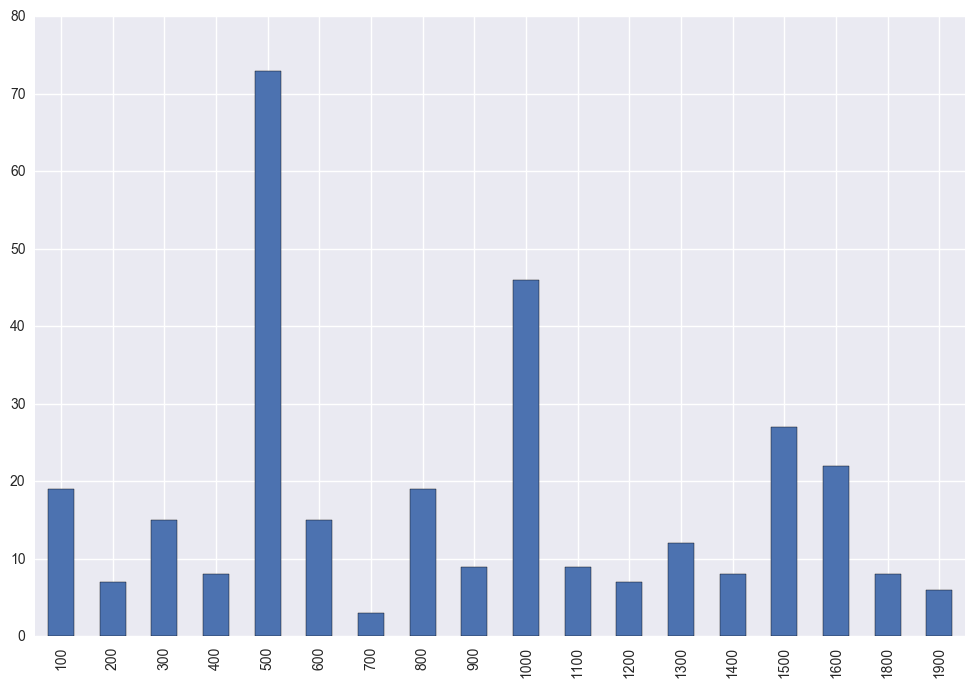

In [17]:
train_df[train_df['compensated'] < 2000].sort_index(by='compensated')['compensated']\
.value_counts().sort_index().plot(kind="bar")

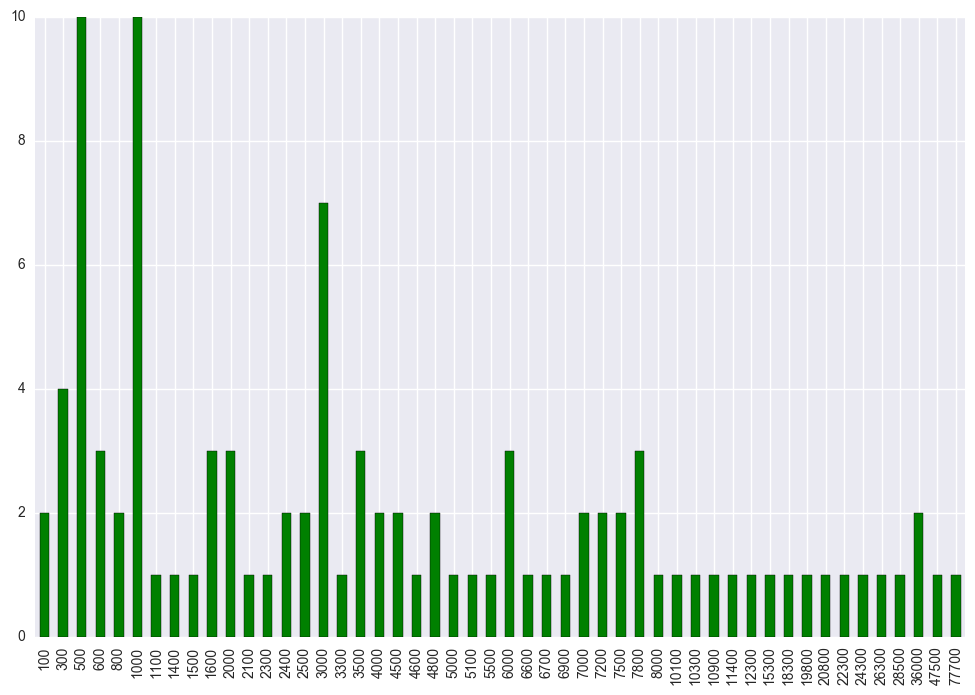

In [18]:
test_df.sort_index(by='compensated')['compensated'].value_counts().sort_index().plot(kind="bar", 
                                                                                     color='green')

**Посмотрим на распеределение классов в обучающей выборке.**

In [19]:
train_df['too_much'].value_counts()

1    422
0    395
Name: too_much, dtype: int64

**Распределение сумм выплат при разных марках автомобиля с указанием целевого класса.**

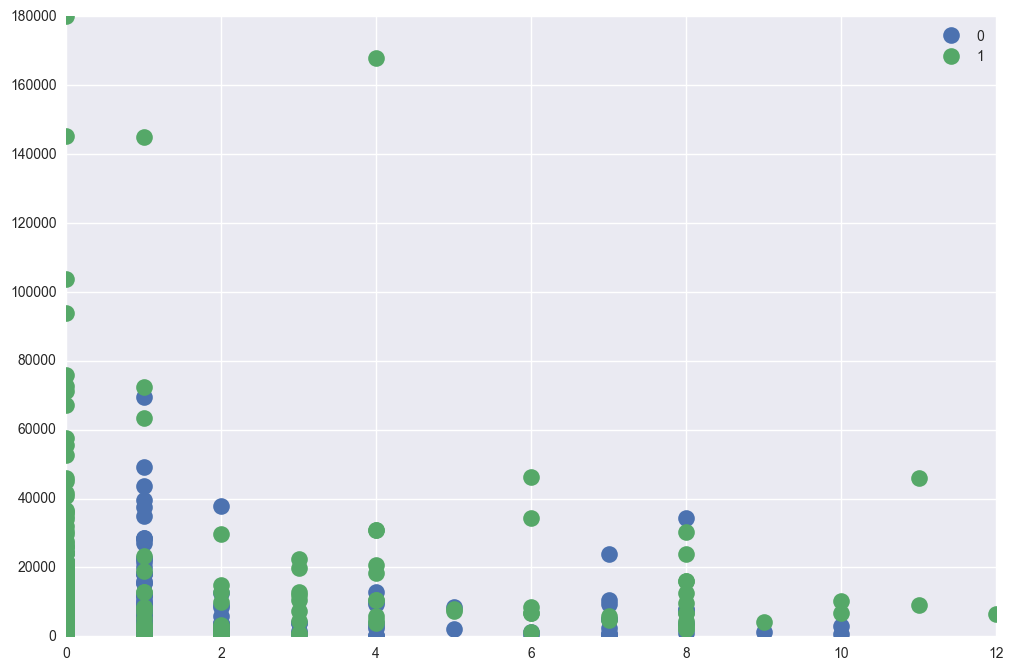

In [20]:
target_groups = train_df.groupby('too_much')
for name, group in target_groups:
    auto_brand_cat = pd.Categorical(group['auto_brand'], categories=group['auto_brand'].unique())
    plot(auto_brand_cat.codes, group['compensated'], marker='o', linestyle='', ms=12, label=name)
    legend()

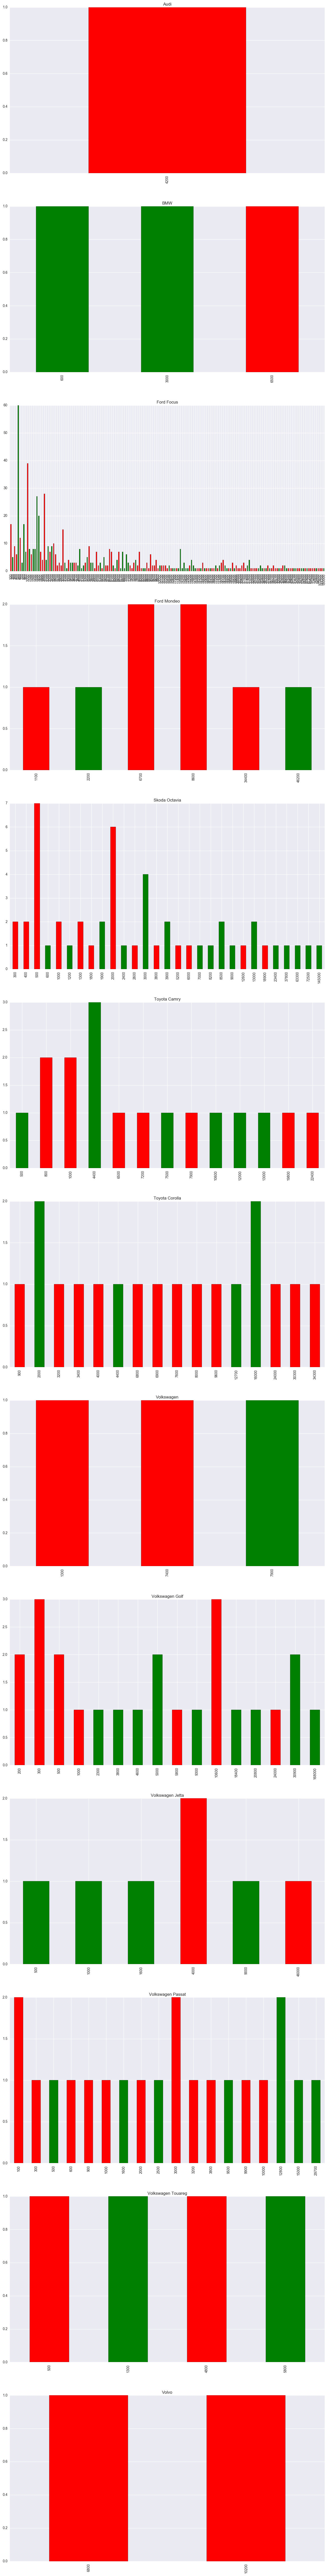

In [21]:
num_unique_brands = len(train_df['auto_brand'].unique())
fig, axes = subplots(nrows=num_unique_brands, ncols=1)

brand_groups = train_df.groupby('auto_brand')
for brand_id, (brand_name, sub_df) in enumerate(brand_groups):
    colors = ['red' if too_much else 'green' 
              for too_much in sub_df['too_much']]
    sub_df['compensated'].value_counts().sort_index().plot(kind="bar", color=colors, 
                                                     ax=axes[brand_id], 
                                                     figsize=(16, 10 * num_unique_brands))
    axes[brand_id].set_title(brand_name)

**Видно, что целевой класс плохо предсказывается только суммой выплат.**

In [22]:
train_df['too_much'].corr(train_df['compensated'])

0.2574494013244038

Значит, есть какие-то неучтенные факторы. Можно, например, попробовать извлечь из номера автомобиля номер регион. Но это позже. Пока поработаем с тем, что есть. Построим на имеющейся выборке дерево решений.

### Подготовка данных

In [23]:
train_df['auto_brand'].head()

id
1      Ford Focus
2    Toyota Camry
3      Ford Focus
4      Ford Focus
5      Ford Focus
Name: auto_brand, dtype: object

In [24]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['auto_brand'], 
                                               prefix='brand')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['auto_brand'], 
                                             prefix='brand')], axis=1)

In [25]:
train_df.head()

,auto_number,auto_brand,compensated,too_much,brand_Audi,brand_BMW,brand_Ford Focus,brand_Ford Mondeo,brand_Skoda Octavia,brand_Toyota Camry,brand_Toyota Corolla,brand_Volkswagen,brand_Volkswagen Golf,brand_Volkswagen Jetta,brand_Volkswagen Passat,brand_Volkswagen Touareg,brand_Volvo
id,,,,,,,,,,,,,,,,,
1,Y163O8161RUS,Ford Focus,3200,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,E432XX77RUS,Toyota Camry,6500,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,7184TT36RUS,Ford Focus,2100,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,X582HE161RUS,Ford Focus,2000,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,E34877152RUS,Ford Focus,6100,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
test_df.head()

,auto_number,auto_brand,compensated,brand_BMW,brand_Ford Focus,brand_Ford Mondeo,brand_Skoda Octavia,brand_Toyota Camry,brand_Toyota Corolla,brand_Volkswagen Golf,brand_Volkswagen Jetta,brand_Volkswagen Passat
id,,,,,,,,,,,,
1,E29677161RUS,Ford Focus,6000,0,1,0,0,0,0,0,0,0
2,T020MM116RUS,Skoda Octavia,3000,0,0,0,1,0,0,0,0,0
3,C798ET50RUS,Ford Focus,5000,0,1,0,0,0,0,0,0,0
4,Y7719C197RUS,Ford Focus,4600,0,1,0,0,0,0,0,0,0
5,9502XX38RUS,Skoda Octavia,3000,0,0,0,1,0,0,0,0,0


In [27]:
train_df.shape, test_df.shape

((817, 17), (100, 12))

**В тестовой выборке нет некоторых марок автомобилей. Создадим для них явно dummy-признаки с нулями.**

In [28]:
set(train_df.columns) - set(test_df.columns)

{'brand_Audi',
 'brand_Volkswagen',
 'brand_Volkswagen Touareg',
 'brand_Volvo',
 'too_much'}

In [29]:
set(test_df.columns) - set(train_df.columns)

set()

In [30]:
test_df['brand_Audi'] = [0] * test_df.shape[0]
test_df['brand_Volkswagen'] = [0] * test_df.shape[0]
test_df['brand_Volkswagen Touareg'] = [0] * test_df.shape[0]
test_df['brand_Volvo'] = [0] * test_df.shape[0]

**Больше не нужны признаки `auto_number` и `auto_brand`. Также вынесем целевой признак в отдельный вектор (точнее, объект pandas Series).**

In [31]:
y = train_df['too_much']

train_df.drop(['auto_number', 'auto_brand', 'too_much'], 
              axis=1, inplace=True)
test_df.drop(['auto_number', 'auto_brand'], 
             axis=1, inplace=True)

In [32]:
train_df.head()

,compensated,brand_Audi,brand_BMW,brand_Ford Focus,brand_Ford Mondeo,brand_Skoda Octavia,brand_Toyota Camry,brand_Toyota Corolla,brand_Volkswagen,brand_Volkswagen Golf,brand_Volkswagen Jetta,brand_Volkswagen Passat,brand_Volkswagen Touareg,brand_Volvo
id,,,,,,,,,,,,,,
1,3200,0,0,1,0,0,0,0,0,0,0,0,0,0
2,6500,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2100,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2000,0,0,1,0,0,0,0,0,0,0,0,0,0
5,6100,0,0,1,0,0,0,0,0,0,0,0,0,0


In [33]:
test_df.head()

,compensated,brand_BMW,brand_Ford Focus,brand_Ford Mondeo,brand_Skoda Octavia,brand_Toyota Camry,brand_Toyota Corolla,brand_Volkswagen Golf,brand_Volkswagen Jetta,brand_Volkswagen Passat,brand_Audi,brand_Volkswagen,brand_Volkswagen Touareg,brand_Volvo
id,,,,,,,,,,,,,,
1,6000,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3000,0,0,0,1,0,0,0,0,0,0,0,0,0
3,5000,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4600,0,1,0,0,0,0,0,0,0,0,0,0,0
5,3000,0,0,0,1,0,0,0,0,0,0,0,0,0


In [34]:
train_df.shape, test_df.shape

((817, 14), (100, 14))

### Обучение дерева решений sklearn.tree.DecisionTreeClassifier

**Пока используем дерево решений без настройки параметров ("из коробки"). <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Документация</a> Scikit-learn по данному классу.**

In [35]:
# make an instance of decision tree classifier
first_tree = DecisionTreeClassifier(max_depth=5, random_state=42)

# fit feautures and target (train set and corresponding labels) to the classifier
first_tree.fit(train_df, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

### Предсказание выплат для тестовой выборки

In [36]:
predicted_probs = first_tree.predict_proba(test_df)[:, 1]

In [37]:
predicted_probs[:10]

array([ 0.7804878 ,  0.52      ,  0.        ,  0.52      ,  0.52      ,
        0.22115385,  0.71153846,  0.71153846,  0.07476636,  0.52      ])

**Запишем ответы в csv-файл (для отправки в Kaggle). Для этого напишем специальную функцию.**

In [38]:
def write_to_submission_file(predicted, out_file,
                             target='too_much', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted,
                                index = np.arange(1, 
                                                  predicted.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [39]:
# export tree visualization
# after that $ dot -Tpng car_insur_first_tree.dot -o car_insur_first_tree.png (PNG format)
export_graphviz(first_tree, 
                out_file="../../output/car_insur_first_tree.dot",
               feature_names=train_df.columns)

<img src="../../img/car_insur_tree.png">

Картинка в формате pdf: `../../img/car_insur_tree.pdf`

**Сравним сразу с ответами (в качестве демонстрации, в реальной задаче ответы, конечно, неизвестны).**

In [40]:
try:
    expected_labels_df = pd.read_csv("../../data/car_insurance_test_labels.csv",
                                     header=0, index_col=0)
    expected_labels = expected_labels_df['too_much']
    print(roc_auc_score(expected_labels, predicted_probs))
except IOError:
    print("You shouldn't know the answers, but this results in ~ 0.68 ROC AUC")

You shouldn't know the answers, but this results in ~ 0.68 ROC AUC


In [41]:
write_to_submission_file(predicted_probs, 
                         "../../output/car_ins_first_DT_dep5.csv")

**В публичном рейтинге в соревновании на Kaggle у этого решения результат - 0.68. Это на половине тестовой выборки, вторая половина откроется в самом конце соревнования. Используем этот результат как Benchmark (Decision tree depth 5 benchmark).**

### Настройка параметров GridSearch

**Указываем наборы параметров дерева решений (критерий поиска лучшего разбиения, максимальная глубина, минимальное число объектов в листе), каждое их сочетание будет проверяться в процессе кросс-валидации (о ней чуть позже).**

In [42]:
# tree params for grid search
tree_params = {'max_depth': list(range(1,11)), 
               'min_samples_leaf': list(range(1,11))}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
locally_best_tree.fit(train_df, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

**Лучшая из перебранных комбинаций параметров:**

In [43]:
locally_best_tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [44]:
locally_best_tree.best_params_

{'max_depth': 3, 'min_samples_leaf': 9}

In [45]:
locally_best_tree.best_score_

0.76454564891509802

In [46]:
try:
    predicted_probs = locally_best_tree.predict_proba(test_df)[:, 1]
    print(roc_auc_score(expected_labels, predicted_probs))
except NameError:
    print("You shouldn't know the answers, but this results in ~ 0.76 ROC AUC")

You shouldn't know the answers, but this results in ~ 0.76 ROC AUC


**На Kaggle у этого решения результат - 0.764 (Decision tree depth 3 benchmark).**

In [47]:
write_to_submission_file(predicted_probs, 
                         "../../output/car_insur_tuned_DT.csv",)

In [48]:
export_graphviz(locally_best_tree.best_estimator_, 
                out_file="../../output/car_ins_tuned_tree.dot",
               feature_names=train_df.columns)

<img src="../../img/car_insur_tuned_tree.png">

Картинка в формате pdf: `../../img/car_insur_tuned_tree.pdf`

### Обучение cлучайного леса sklearn.ensemble.RandomForestClassifier

Про случайный лес подробней поговорим позже. Интуитивно: улучшение качества классификации по сравнению с одни деревом решений происходит потому, что разделяющая поверхность одного дерева - многомерный параллелепипед, тогда как граница, построенная Random Forest, получается более сложной.  

In [49]:
# tree params for grid search
forest_params = {'n_estimators': [100, 500],
               'max_depth': list(range(2,5)), 
               'min_samples_leaf': list(range(2,5))}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                                 forest_params, 
                                 verbose=True, n_jobs=-1, cv=5)
locally_best_forest.fit(train_df, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 3, 4], 'n_estimators': [100, 500], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [50]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 500},
 0.72460220318237456)

In [51]:
try:
    predicted_probs = locally_best_forest.predict_proba(test_df)[:, 1]
    print(roc_auc_score(expected_labels, predicted_labels))
except NameError:
    print("You shouldn't know the answers, but this results in ~ 0.75 ROC AUC")

You shouldn't know the answers, but this results in ~ 0.75 ROC AUC


In [52]:
write_to_submission_file(predicted_probs, 
                         "../../output/car_insur_RF_dep4_n500.csv")

**На Kaggle у этого решения результат - 0.786 (RF 500 est depth 3 benchmark).**

## Ссылки
- [Соревнование](https://inclass.kaggle.com/c/hse-addprofeduc-2-ml-contest) на сайте Kaggle Inclass
- Исходное <a href="http://microsoftbi.ru/2015/06/06/hackathon2015ml/">описание</a> задачи
-  Документация Scikit-learn по классам <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a> и <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a>